In [1]:
import numpy as np
import pandas as pd
from openbb_terminal.sdk import openbb
from statsforecast.models import AutoARIMA
import requests
import re

import altair as alt
from scipy.linalg import svd
#import lineapy

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
%matplotlib inline

# Turn off warnings and messages 
import warnings
warnings.filterwarnings('ignore')

Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

In [2]:
btc_df = openbb.crypto.load(symbol="btc",to_symbol="usd",start_date="2019-01-01",source="YahooFinance")
eth_df = openbb.crypto.load(symbol="eth",to_symbol="usd",start_date="2019-01-01",source="YahooFinance")
xrp_df= openbb.crypto.load(symbol='xrp', to_symbol='usd', start_date='2019-01-01', source="YahooFinance")
# Combine btc and eth dataframes and save under /data. Append current date to the filename. 
# Add a new column identifying which coin the row belongs to. 
btc_df['coin'] = 'btc'
eth_df['coin'] = 'eth'
xrp_df['coin']= 'xrp'
btc_eth_df = pd.concat([btc_df,eth_df],axis=0)

btc_eth_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,coin
date,,,,,,,
2023-09-29,1652.999878,1687.281250,1648.656494,1667.943848,1667.943848,5529687537,eth
2023-09-30,1667.834473,1692.531128,1666.563843,1671.161865,1671.161865,3155292192,eth
2023-10-01,1671.161499,1750.595703,1670.082153,1733.810425,1733.810425,5054880180,eth
2023-10-02,1732.984009,1743.563599,1646.077637,1663.627563,1663.627563,8420552922,eth
2023-10-03,1662.887207,1670.356323,1644.496460,1656.685669,1656.685669,4742827302,eth


In [3]:
btc= btc_eth_df[btc_eth_df.coin == 'btc']
btc.head()

,Open,High,Low,Close,Adj Close,Volume,coin
date,,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,btc
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,btc
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,btc
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,btc
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,btc


In [4]:
btc.head()
btc= btc.reset_index()

In [5]:
btc['date'] = btc['date'].astype(str)  # Convert the column to a string
splitted= btc.date.str.split('-', expand=True)
btc['year']= splitted[0].astype('int')
btc['month']= splitted[1].astype('int')
btc['day']= splitted[2].astype('int')
btc.head()

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,day
0,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,btc,2019,1,1
1,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,btc,2019,1,2
2,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,btc,2019,1,3
3,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,btc,2019,1,4
4,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,btc,2019,1,5


In [6]:
btc['is_quarter_end']= np.where(btc['month']%3==0,1,0)
btc.tail()

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,day,is_quarter_end
1732,2023-09-29,27024.841797,27225.937500,26721.763672,26911.720703,26911.720703,10396435377,btc,2023,9,29,1
1733,2023-09-30,26911.689453,27091.794922,26888.968750,26967.916016,26967.916016,5331172801,btc,2023,9,30,1
1734,2023-10-01,26967.396484,28047.238281,26965.093750,27983.750000,27983.750000,9503917434,btc,2023,10,1,0
1735,2023-10-02,27976.798828,28494.458984,27347.787109,27530.785156,27530.785156,19793041322,btc,2023,10,2,0
1736,2023-10-03,27508.251953,27667.191406,27216.001953,27429.978516,27429.978516,11407814187,btc,2023,10,3,0


In [7]:
btc['open-close']= btc['Open']- btc['Close']
btc['low-high']= btc['Low']- btc['High']
btc['target']= np.where(btc['Close'].shift(-1) > btc.Close, 1, 0)
btc.head()

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,day,is_quarter_end,open-close,low-high,target
0,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,btc,2019,1,1,0,-96.806641,-143.682617,1
1,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,btc,2019,1,2,0,-94.193115,-130.571777,0
2,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,btc,2019,1,3,0,94.307373,-109.462158,1
3,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,btc,2019,1,4,0,-25.677490,-82.080811,0
4,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,btc,2019,1,5,0,6.779297,-68.002930,1


In [8]:
!pip install xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics 
import warnings 
warnings.filterwarnings('ignore')
features= btc[['open-close', 'low-high', 'is_quarter_end']]
target= btc['target']

scaler= StandardScaler()
features= scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid= train_test_split(features, target, test_size=0.1, random_state=202)
print(X_train.shape, X_valid.shape)

(1563, 3) (174, 3)


In [9]:
models= [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
    models[i].fit(X_train, Y_train)
    
    print(f'{models[i]} :')
    print('Training Acc: ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Test Acc :', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))
    print()

LogisticRegression() :
Training Acc:  0.5377479646829493
Test Acc : 0.5617650944642623

SVC(kernel='poly', probability=True) :
Training Acc:  0.4732583091716218
Test Acc : 0.5151274937244023

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) :
Training Acc:  0.9528731960620507
Test Acc : 0.5

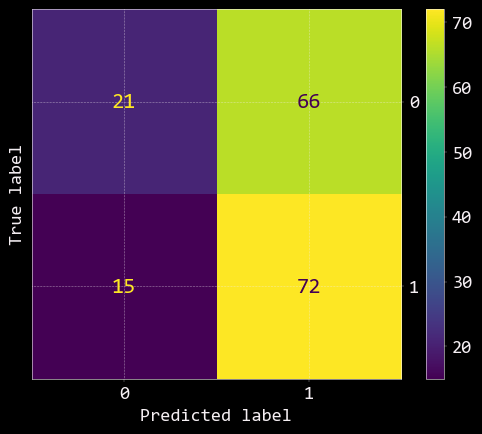

In [10]:
import matplotlib.pyplot as plt
metrics.plot_confusion_matrix(models[0], X_valid, Y_valid)
plt.show()

In [11]:
# Define the time period for RSI calculation (e.g., 14 days)
period = 14

# Calculate daily price changes
btc['Price Change'] = btc['Close'].diff()

# Separate gains (positive changes) and losses (negative changes)
btc['Gain'] = btc['Price Change'].apply(lambda x: x if x > 0 else 0)
btc['Loss'] = btc['Price Change'].apply(lambda x: abs(x) if x < 0 else 0)

# Calculate average gains and average losses over the specified period
btc['Avg Gain'] = btc['Gain'].rolling(window=period).mean()
btc['Avg Loss'] = btc['Loss'].rolling(window=period).mean()

# Calculate RS (Relative Strength)
btc['RS'] = btc['Avg Gain'] / btc['Avg Loss']

# Calculate RSI
btc['RSI'] = 100 - (100 / (1 + btc['RS']))

# Drop rows with missing values (due to the rolling averages)
btc = btc.dropna()

# Save the updated dataset with RSI values
btc.to_csv('updated_dataset_with_RSI.csv', index=False)


In [12]:
import pandas as pd
import numpy as np



# Sort the DataFrame by date (if it's not already sorted)
btc.sort_values(by='date', inplace=True)

# Calculate Simple Moving Average (SMA)
sma_period = 3  # Adjust as needed
btc['SMA'] = btc['Close'].rolling(window=sma_period).mean()

# Calculate Relative Strength Index (RSI)
rsi_period = 14  # Adjust as needed
delta = btc['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=rsi_period).mean()
avg_loss = loss.rolling(window=rsi_period).mean()
rs = avg_gain / avg_loss
btc['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Average Convergence Divergence (MACD)
macd_fast_period = 12  # Adjust as needed
macd_slow_period = 26  # Adjust as needed
signal_period = 9  # Adjust as needed
ema_fast = btc['Close'].ewm(span=macd_fast_period).mean()
ema_slow = btc['Close'].ewm(span=macd_slow_period).mean()
btc['MACD'] = ema_fast - ema_slow
btc['Signal'] = btc['MACD'].ewm(span=signal_period).mean()

# Calculate Bollinger Bands
bb_period = 20  # Adjust as needed
btc['Middle_Band'] = btc['Close'].rolling(window=bb_period).mean()
btc['Upper_Band'] = btc['Middle_Band'] + (2 * btc['Close'].rolling(window=bb_period).std())
btc['Lower_Band'] = btc['Middle_Band'] - (2 * btc['Close'].rolling(window=bb_period).std())

# Calculate Stochastic Oscillator
k_period = 14  # Adjust as needed
d_period = 3  # Adjust as needed
low_min = btc['Low'].rolling(window=k_period).min()
high_max = btc['High'].rolling(window=k_period).max()
btc['%K'] = ((btc['Close'] - low_min) / (high_max - low_min)) * 100
btc['%D'] = btc['%K'].rolling(window=d_period).mean()

# Calculate Average True Range (ATR)
atr_period = 14  # Adjust as needed
tr = np.maximum(np.maximum(btc['High'] - btc['Low'], abs(btc['High'] - btc['Close'].shift(1))),
                abs(btc['Low'] - btc['Close'].shift(1)))
btc['ATR'] = tr.rolling(window=atr_period).mean()

# Print or further analyze the DataFrame with manually calculated technical indicators
btc

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,...,RSI,SMA,MACD,Signal,Middle_Band,Upper_Band,Lower_Band,%K,%D,ATR
13,2019-01-14,3557.311035,3727.836182,3552.285156,3706.052246,3706.052246,5651384490,btc,2019,1,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
14,2019-01-15,3704.216309,3720.153320,3619.949219,3630.675293,3630.675293,5537192302,btc,2019,1,...,NaN,NaN,-1.691150,-0.939528,NaN,NaN,NaN,NaN,NaN,NaN
15,2019-01-16,3631.509766,3685.777100,3624.673340,3655.006836,3655.006836,5394457145,btc,2019,1,...,NaN,3663.911458,-1.400341,-1.128385,NaN,NaN,NaN,NaN,NaN,NaN
16,2019-01-17,3651.871094,3680.135986,3621.960938,3678.563965,3678.563965,5464420383,btc,2019,1,...,NaN,3654.748698,-0.383235,-0.875963,NaN,NaN,NaN,NaN,NaN,NaN
17,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727,btc,2019,1,...,NaN,3663.803385,-0.647167,-0.807901,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,2023-09-29,27024.841797,27225.937500,26721.763672,26911.720703,26911.720703,10396435377,btc,2023,9,...,55.476519,26761.994792,23.539403,-43.486795,26459.496191,27418.548210,25500.444173,60.939217,50.804076,516.457171
1733,2023-09-30,26911.689453,27091.794922,26888.968750,26967.916016,26967.916016,5331172801,btc,2023,9,...,57.181505,26967.061198,52.596116,-24.270212,26516.280664,27453.184038,25579.377290,64.743150,64.685286,510.881975
1734,2023-10-01,26967.396484,28047.238281,26965.093750,27983.750000,27983.750000,9503917434,btc,2023,10,...,69.254953,27287.795573,155.797152,11.743260,26657.335449,27585.573797,25729.097102,96.881362,74.187910,575.826311
1735,2023-10-02,27976.798828,28494.458984,27347.787109,27530.785156,27530.785156,19793041322,btc,2023,10,...,59.713584,27494.150391,198.743250,49.143258,26742.207520,27663.603742,25820.811297,61.188980,74.271164,586.358677


In [13]:
btc_supply_data=openbb.crypto.onchain.btc_supply()
btc_supply_data

,x,y
0,2009-01-03 18:15:05,50.00
1,2009-01-15 02:35:58,26450.00
2,2009-01-19 19:12:52,52850.00
3,2009-01-24 13:33:46,79250.00
4,2009-01-28 12:41:55,105650.00
...,...,...
1495,2023-09-17 11:04:08,19488250.00
1496,2023-09-21 01:35:24,19491562.50
1497,2023-09-24 18:01:39,19494868.75
1498,2023-09-28 09:11:48,19498175.00


In [14]:

# Rename the 'x' column to 'date' and 'y' column to 'btc_supply'
btc_supply_data.rename(columns={'x': 'date', 'y': 'btc_supply'}, inplace=True)

# Convert the 'date' column to a datetime data type
btc_supply_data['date'] = pd.to_datetime(btc_supply_data['date'])

# Extract only the date part from the 'date' column
btc_supply_data['date'] = btc_supply_data['date'].dt.date

# Now your DataFrame should have 'date' as the date without time and 'btc_supply'
btc_supply_data.head()


,date,btc_supply
0,2009-01-03,50.0
1,2009-01-15,26450.0
2,2009-01-19,52850.0
3,2009-01-24,79250.0
4,2009-01-28,105650.0


In [15]:
# Convert 'date' columns to datetime objects with the same format
btc['date'] = pd.to_datetime(btc['date'])
btc_supply_data['date'] = pd.to_datetime(btc_supply_data['date'])

# Extract only the date part (remove time)
btc['date'] = btc['date'].dt.date
btc_supply_data['date'] = btc_supply_data['date'].dt.date

# Now, try the merge again
merged_data = btc.merge(btc_supply_data, on='date', how='left', suffixes=('_left', '_right'))
merged_data

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,...,SMA,MACD,Signal,Middle_Band,Upper_Band,Lower_Band,%K,%D,ATR,btc_supply
0,2019-01-14,3557.311035,3727.836182,3552.285156,3706.052246,3706.052246,5651384490,btc,2019,1,...,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,17481325.0
1,2019-01-15,3704.216309,3720.153320,3619.949219,3630.675293,3630.675293,5537192302,btc,2019,1,...,NaN,-1.691150,-0.939528,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-16,3631.509766,3685.777100,3624.673340,3655.006836,3655.006836,5394457145,btc,2019,1,...,3663.911458,-1.400341,-1.128385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-17,3651.871094,3680.135986,3621.960938,3678.563965,3678.563965,5464420383,btc,2019,1,...,3654.748698,-0.383235,-0.875963,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727,btc,2019,1,...,3663.803385,-0.647167,-0.807901,NaN,NaN,NaN,NaN,NaN,NaN,17487950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,2023-09-29,27024.841797,27225.937500,26721.763672,26911.720703,26911.720703,10396435377,btc,2023,9,...,26761.994792,23.539403,-43.486795,26459.496191,27418.548210,25500.444173,60.939217,50.804076,516.457171,NaN
1720,2023-09-30,26911.689453,27091.794922,26888.968750,26967.916016,26967.916016,5331172801,btc,2023,9,...,26967.061198,52.596116,-24.270212,26516.280664,27453.184038,25579.377290,64.743150,64.685286,510.881975,NaN
1721,2023-10-01,26967.396484,28047.238281,26965.093750,27983.750000,27983.750000,9503917434,btc,2023,10,...,27287.795573,155.797152,11.743260,26657.335449,27585.573797,25729.097102,96.881362,74.187910,575.826311,NaN
1722,2023-10-02,27976.798828,28494.458984,27347.787109,27530.785156,27530.785156,19793041322,btc,2023,10,...,27494.150391,198.743250,49.143258,26742.207520,27663.603742,25820.811297,61.188980,74.271164,586.358677,19501487.5


In [16]:
x= openbb.crypto.onchain.btc_transac()
x.rename(columns={'x': 'date', 'y': 'confirmed_transactions'}, inplace=True)
x['date'] = pd.to_datetime(x['date'])
x['date'] = x['date'].dt.date

In [17]:
# Now, try the merge again
merged_data = merged_data.merge(x, on='date', how='left', suffixes=('_left', '_right'))
merged_data

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,...,MACD,Signal,Middle_Band,Upper_Band,Lower_Band,%K,%D,ATR,btc_supply,confirmed_transactions
0,2019-01-14,3557.311035,3727.836182,3552.285156,3706.052246,3706.052246,5651384490,btc,2019,1,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,17481325.0,NaN
1,2019-01-15,3704.216309,3720.153320,3619.949219,3630.675293,3630.675293,5537192302,btc,2019,1,...,-1.691150,-0.939528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-16,3631.509766,3685.777100,3624.673340,3655.006836,3655.006836,5394457145,btc,2019,1,...,-1.400341,-1.128385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-17,3651.871094,3680.135986,3621.960938,3678.563965,3678.563965,5464420383,btc,2019,1,...,-0.383235,-0.875963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296695.0
4,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727,btc,2019,1,...,-0.647167,-0.807901,NaN,NaN,NaN,NaN,NaN,NaN,17487950.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,2023-09-29,27024.841797,27225.937500,26721.763672,26911.720703,26911.720703,10396435377,btc,2023,9,...,23.539403,-43.486795,26459.496191,27418.548210,25500.444173,60.939217,50.804076,516.457171,NaN,330269.0
1720,2023-09-30,26911.689453,27091.794922,26888.968750,26967.916016,26967.916016,5331172801,btc,2023,9,...,52.596116,-24.270212,26516.280664,27453.184038,25579.377290,64.743150,64.685286,510.881975,NaN,NaN
1721,2023-10-01,26967.396484,28047.238281,26965.093750,27983.750000,27983.750000,9503917434,btc,2023,10,...,155.797152,11.743260,26657.335449,27585.573797,25729.097102,96.881362,74.187910,575.826311,NaN,NaN
1722,2023-10-02,27976.798828,28494.458984,27347.787109,27530.785156,27530.785156,19793041322,btc,2023,10,...,198.743250,49.143258,26742.207520,27663.603742,25820.811297,61.188980,74.271164,586.358677,19501487.5,NaN


In [18]:
openbb.economy

EconomyRoot(

Attributes:
    available_indices: Get available indices
    balance: General government deficit is defined as the balance of income and expenditure of government,
    balance_chart: General government balance is defined as the balance of income and expenditure of government,
    bigmac: Display Big Mac Index for given countries
    bigmac_chart: Display Big Mac Index for given countries
    ccpi: Inflation measured by consumer price index (CPI) is defined as the change in the prices
    ccpi_chart: Inflation measured by consumer price index (CPI) is defined as the change in the prices
    country_codes: Get available country codes for Bigmac index
    cpi: Obtain CPI data from FRED. [Source: FRED]
    cpi_chart: Inflation measured by consumer price index (CPI) is defined as the change in
    currencies: Scrape data for global currencies
    debt: General government debt-to-GDP ratio measures the gross debt of the general
    debt_chart: General government debt-to-GDP rat

In [19]:
trust= openbb.economy.trust(countries=['united_states'])
trust.rename(columns={'united_states': 'trust_in_us_gov'}, inplace=True)
trust.reset_index(inplace=True)
# Convert the 'time' column to a datetime object and extract the year
trust['year'] = pd.to_datetime(trust['TIME']).dt.year
trust.tail()

,TIME,trust_in_us_gov,year
12,2018-01-01,31.381609,2018
13,2019-01-01,36.277444,2019
14,2020-01-01,46.491709,2020
15,2021-01-01,40.462522,2021
16,2022-01-01,31.024156,2022


In [20]:
# Now, try the merge again
merged_data = merged_data.merge(trust, on='year', how='left', suffixes=('_left', '_right'))
merged_data

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,...,Middle_Band,Upper_Band,Lower_Band,%K,%D,ATR,btc_supply,confirmed_transactions,TIME,trust_in_us_gov
0,2019-01-14,3557.311035,3727.836182,3552.285156,3706.052246,3706.052246,5651384490,btc,2019,1,...,NaN,NaN,NaN,NaN,NaN,NaN,17481325.0,NaN,2019-01-01,36.277444
1,2019-01-15,3704.216309,3720.153320,3619.949219,3630.675293,3630.675293,5537192302,btc,2019,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01,36.277444
2,2019-01-16,3631.509766,3685.777100,3624.673340,3655.006836,3655.006836,5394457145,btc,2019,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01,36.277444
3,2019-01-17,3651.871094,3680.135986,3621.960938,3678.563965,3678.563965,5464420383,btc,2019,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296695.0,2019-01-01,36.277444
4,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727,btc,2019,1,...,NaN,NaN,NaN,NaN,NaN,NaN,17487950.0,NaN,2019-01-01,36.277444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,2023-09-29,27024.841797,27225.937500,26721.763672,26911.720703,26911.720703,10396435377,btc,2023,9,...,26459.496191,27418.548210,25500.444173,60.939217,50.804076,516.457171,NaN,330269.0,NaT,NaN
1720,2023-09-30,26911.689453,27091.794922,26888.968750,26967.916016,26967.916016,5331172801,btc,2023,9,...,26516.280664,27453.184038,25579.377290,64.743150,64.685286,510.881975,NaN,NaN,NaT,NaN
1721,2023-10-01,26967.396484,28047.238281,26965.093750,27983.750000,27983.750000,9503917434,btc,2023,10,...,26657.335449,27585.573797,25729.097102,96.881362,74.187910,575.826311,NaN,NaN,NaT,NaN
1722,2023-10-02,27976.798828,28494.458984,27347.787109,27530.785156,27530.785156,19793041322,btc,2023,10,...,26742.207520,27663.603742,25820.811297,61.188980,74.271164,586.358677,19501487.5,NaN,NaT,NaN


In [21]:
merged_data.columns

Index(['date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'coin',
       'year', 'month', 'day', 'is_quarter_end', 'open-close', 'low-high',
       'target', 'Price Change', 'Gain', 'Loss', 'Avg Gain', 'Avg Loss', 'RS',
       'RSI', 'SMA', 'MACD', 'Signal', 'Middle_Band', 'Upper_Band',
       'Lower_Band', '%K', '%D', 'ATR', 'btc_supply', 'confirmed_transactions',
       'TIME', 'trust_in_us_gov'],
      dtype='object')

In [22]:
treasury= openbb.economy.treasury()
treasury.reset_index(inplace=True)
import pandas as pd

# Assuming 'date_column' is the name of the column you want to convert
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Now, 'date_column' is converted to a datetime dtype
merged_data = merged_data.merge(treasury, on='date', how='left', suffixes=('_left', '_right'))
merged_data

,date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,...,3m,6m,1y,2y,3y,5y,7y,10y,20y,30y
0,2019-01-14,3557.311035,3727.836182,3552.285156,3706.052246,3706.052246,5651384490,btc,2019,1,...,2.45,2.52,2.57,2.53,2.51,2.53,2.6,2.71,2.91,3.06
1,2019-01-15,3704.216309,3720.153320,3619.949219,3630.675293,3630.675293,5537192302,btc,2019,1,...,2.45,2.52,2.57,2.53,2.51,2.53,2.61,2.72,2.92,3.08
2,2019-01-16,3631.509766,3685.777100,3624.673340,3655.006836,3655.006836,5394457145,btc,2019,1,...,2.43,2.49,2.57,2.55,2.53,2.54,2.62,2.73,2.92,3.07
3,2019-01-17,3651.871094,3680.135986,3621.960938,3678.563965,3678.563965,5464420383,btc,2019,1,...,2.42,2.5,2.57,2.56,2.55,2.58,2.66,2.75,2.93,3.07
4,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727,btc,2019,1,...,2.41,2.5,2.6,2.62,2.6,2.62,2.7,2.79,2.95,3.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,2023-09-29,27024.841797,27225.937500,26721.763672,26911.720703,26911.720703,10396435377,btc,2023,9,...,5.55,5.53,5.46,5.03,4.8,4.6,4.61,4.59,4.92,4.73
1720,2023-09-30,26911.689453,27091.794922,26888.968750,26967.916016,26967.916016,5331172801,btc,2023,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1721,2023-10-01,26967.396484,28047.238281,26965.093750,27983.750000,27983.750000,9503917434,btc,2023,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1722,2023-10-02,27976.798828,28494.458984,27347.787109,27530.785156,27530.785156,19793041322,btc,2023,10,...,5.62,5.58,5.49,5.12,4.88,4.72,4.73,4.69,5.0,4.81


In [23]:
spending= openbb.economy.spending(countries=['united_states'])
spending.rename(columns={'united_states':'Spending United States'}, inplace=True)
spending.reset_index(inplace=True)
spending['year']= pd.to_datetime(spending['TIME']).dt.year
merged_data = merged_data.merge(spending, on='year',how='left', suffixes=('_left', '_right'))
merged_data.shape

(1724, 48)

In [24]:
# Convert the 'date' column to a datetime object and extract the quarter
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['quarter_year'] = 'Q' + merged_data['date'].dt.quarter.astype(str) + '_' + merged_data['date'].dt.year.astype(str)
merged_data.quarter_year.value_counts()

Q3_2021    92
Q4_2021    92
Q3_2019    92
Q4_2019    92
Q4_2022    92
Q3_2022    92
Q3_2020    92
Q4_2020    92
Q3_2023    92
Q2_2022    91
Q2_2021    91
Q2_2019    91
Q2_2020    91
Q1_2020    91
Q2_2023    91
Q1_2022    90
Q1_2021    90
Q1_2023    90
Q1_2019    77
Q4_2023     3
Name: quarter_year, dtype: int64

In [25]:
merged_data.shape

(1724, 49)

In [26]:
rgdp= openbb.economy.rgdp(countries=['united_states'])
rgdp.reset_index(inplace=True)
rgdp.rename(columns={'united_states': 'Gross domestic product (GDP) US'}, inplace=True)
# Convert the 'date' column to a datetime object and extract the quarter
rgdp['TIME'] = pd.to_datetime(rgdp['TIME'])
rgdp['quarter_year'] = 'Q' + rgdp['TIME'].dt.quarter.astype(str) + '_' + rgdp['TIME'].dt.year.astype(str)

rgdp.tail(2)

,TIME,Gross domestic product (GDP) US,quarter_year
36,2023-01-01,1.800193,Q1_2023
37,2023-04-01,2.468908,Q2_2023


In [27]:
merged_data = merged_data.merge(rgdp, on='quarter_year',how='left', suffixes=('_left', '_right'))
merged_data.shape

(1724, 51)

In [28]:
revenue= openbb.economy.revenue(countries=['united_states'])
revenue.reset_index(inplace=True)
revenue.rename(columns={'united_states': 'Revenue US'}, inplace=True)
# Convert the 'date' column to a datetime object and extract the quarter
revenue['TIME'] = pd.to_datetime(revenue['TIME'])
revenue['year']= pd.to_datetime(revenue['TIME']).dt.year
revenue.tail()

,TIME,Revenue US,year
23,2017-01-01,33.635151,2017
24,2018-01-01,31.868441,2018
25,2019-01-01,31.795123,2019
26,2020-01-01,32.446053,2020
27,2021-01-01,32.873295,2021


In [29]:
merged_data = merged_data.merge(revenue, on='year',how='left', suffixes=('_left', '_right'))
merged_data.shape

(1724, 53)

In [30]:
index= openbb.economy.index(indices=['sp500', 'nyse', 'crypto200', 'cboe_vix3m'])
index.reset_index(inplace=True)
index.rename(columns={'crypto200': 'CMC Crypto 200 Index by Solacti', 'cboe_vix3m': 'CBOE S&P 500 3-Month Volatility Index', 'Date': 'date'}, inplace=True)
index

yfinance: download(show_errors=False) argument is deprecated and will be removed in future version. Do this instead to suppress error messages: logging.getLogger('yfinance').setLevel(logging.CRITICAL)


,date,sp500,nyse,CMC Crypto 200 Index by Solacti,CBOE S&P 500 3-Month Volatility Index
0,1927-12-30,17.660000,NaN,NaN,NaN
1,1928-01-03,17.760000,NaN,NaN,NaN
2,1928-01-04,17.719999,NaN,NaN,NaN
3,1928-01-05,17.549999,NaN,NaN,NaN
4,1928-01-06,17.660000,NaN,NaN,NaN
...,...,...,...,...,...
24050,2023-09-28,4299.700195,15478.070312,579.830017,18.379999
24051,2023-09-29,4288.049805,15398.209961,579.661987,18.510000
24052,2023-10-02,4288.390137,15230.009766,589.086975,18.620001
24053,2023-10-03,4229.450195,15043.419922,583.513977,20.410000


In [31]:
merged_data = merged_data.merge(index, on='date',how='left', suffixes=('_left', '_right'))
merged_data.shape

(1724, 57)

In [32]:
balance=openbb.economy.balance(countries= ['united_states'])
balance.reset_index(inplace=True)
balance.rename(columns={'united_states': 'Balance US'}, inplace=True)
balance['TIME'] = pd.to_datetime(balance['TIME'])
balance['year']= pd.to_datetime(balance['TIME']).dt.year
balance.tail(2)

,TIME,Balance US,year
26,2020-01-01,-14.859978,2020
27,2021-01-01,-12.064339,2021


In [33]:
merged_data = merged_data.merge(balance, on='year',how='left', suffixes=('_left', '_right'))
merged_data.shape

(1724, 59)

In [34]:
#Inflation measured by consumer price index (CPI)
ccpi= openbb.economy.ccpi(countries=['united_states'])
ccpi.reset_index(inplace=True)
ccpi.rename(columns={'united_states': 'consumer price index(ccpi inflation measure) US'}, inplace=True)
# Convert the 'date' column to a datetime object and extract the quarter
ccpi['TIME'] = pd.to_datetime(ccpi['TIME'])
ccpi['quarter_year'] = 'Q' + ccpi['TIME'].dt.quarter.astype(str) + '_' + ccpi['TIME'].dt.year.astype(str)
ccpi.tail()

,TIME,consumer price index(ccpi inflation measure) US,quarter_year
13,2022-04-01,8.635612,Q2_2022
14,2022-07-01,8.329475,Q3_2022
15,2022-10-01,7.101672,Q4_2022
16,2023-01-01,5.804770,Q1_2023
17,2023-04-01,3.974292,Q2_2023


In [35]:
merged_data = merged_data.merge(ccpi, on='quarter_year',how='left', suffixes=('_left', '_right'))
merged_data.shape

(1724, 61)

In [36]:
debt= openbb.economy.debt(countries=['united_states'])
debt.reset_index(inplace=True)
debt.rename(columns={'united_states': 'debt-to-GDP ratio US'}, inplace=True)
debt['TIME'] = pd.to_datetime(debt['TIME'])
debt['year']= pd.to_datetime(debt['TIME']).dt.year
debt.tail(5)

,TIME,debt-to-GDP ratio US,year
23,2018-01-01,137.3158,2018
24,2019-01-01,136.1380,2019
25,2020-01-01,159.9110,2020
26,2021-01-01,148.0516,2021
27,2022-01-01,144.0216,2022


In [37]:
merged_data = merged_data.merge(debt, on='year',how='left', suffixes=('_left', '_right'))
merged_data.shape

(1724, 63)

In [38]:
#Real gross domestic product (GDP)
fgdp= openbb.economy.fgdp(countries=['united_states'])
fgdp.reset_index(inplace=True)
fgdp.rename(columns={'united_states': 'Real gross domestic product (GDP) US'}, inplace=True)
# Convert the 'date' column to a datetime object and extract the quarter
fgdp['TIME'] = pd.to_datetime(fgdp['TIME'])
fgdp['quarter_year'] = 'Q' + fgdp['TIME'].dt.quarter.astype(str) + '_' + fgdp['TIME'].dt.year.astype(str)
fgdp.tail(5)

,TIME,Real gross domestic product (GDP) US,quarter_year
39,2023-10-01,0.458808,Q4_2023
40,2024-01-01,0.812100,Q1_2024
41,2024-04-01,1.111783,Q2_2024
42,2024-07-01,1.484327,Q3_2024
43,2024-10-01,1.744959,Q4_2024


In [39]:
merged_data = merged_data.merge(fgdp, on='quarter_year',how='left', suffixes=('_left', '_right'))
merged_data.shape

(1724, 65)

In [40]:
gdp= openbb.economy.gdp(countries=['united_states'])
gdp.reset_index(inplace=True)
gdp.rename(columns={'united_states': 'GDP per Capita US'}, inplace=True)
# Convert the 'date' column to a datetime object and extract the quarter
gdp['TIME'] = pd.to_datetime(gdp['TIME'])
gdp['year'] = gdp['TIME'].dt.year
gdp.tail(5)

,TIME,GDP per Capita US,year
24,2018-01-01,62449.612827,2018
25,2019-01-01,64690.272395,2019
26,2020-01-01,63480.861222,2020
27,2021-01-01,70181.121750,2021
28,2022-01-01,76359.999520,2022


In [41]:
merged_data = merged_data.merge(gdp, on='year',how='left', suffixes=('_left', '_right'))
merged_data.shape

(1724, 67)

In [42]:
bb= openbb.economy

In [43]:
data_tuple= bb.macro()
# Extract the DataFrame from the tuple
cpi_df = data_tuple[0]

# Reset the index to make 'date' a column
cpi_df.reset_index(inplace=True)

# Rename the columns
cpi_df.columns = ['date', 'CPI']

# Convert 'date' column to datetime type
cpi_df['date'] = pd.to_datetime(cpi_df['date'])

# Print the DataFrame
cpi_df



,date,CPI
0,1947-01-01,21.480000
1,1947-02-01,21.620001
2,1947-03-01,22.000000
3,1947-04-01,22.000000
4,1947-05-01,21.950001
...,...,...
915,2023-04-01,302.899994
916,2023-05-01,303.299988
917,2023-06-01,303.799988
918,2023-07-01,304.299988


In [44]:
cpi_df['year_month'] = cpi_df['date'].dt.strftime('%Y-%m')
cpi_df.rename(columns={'CPI': 'US CPI'}, inplace=True)
merged_data['year_month']= merged_data['date'].dt.strftime('%Y-%m')

In [45]:
merged_data = merged_data.merge(cpi_df, on='year_month',how='left', suffixes=('_left', '_right'))
merged_data.shape

(1724, 70)

In [46]:
merged_data.rename(columns={'date_left': 'Date'}, inplace=True)

In [47]:
merged_data.columns
merged_data.drop(columns={'TIME_right', 'TIME_left', 'date_right'}, inplace=True)

In [48]:
pd.set_option('display.max_columns', None)

merged_data

,Date,Open,High,Low,Close,Adj Close,Volume,coin,year,month,day,is_quarter_end,open-close,low-high,target,Price Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI,SMA,MACD,Signal,Middle_Band,Upper_Band,Lower_Band,%K,%D,ATR,btc_supply,confirmed_transactions,trust_in_us_gov,1m,3m,6m,1y,2y,3y,5y,7y,10y,20y,30y,Spending United States,quarter_year,Gross domestic product (GDP) US,Revenue US,sp500,nyse,CMC Crypto 200 Index by Solacti,CBOE S&P 500 3-Month Volatility Index,Balance US,consumer price index(ccpi inflation measure) US,debt-to-GDP ratio US,Real gross domestic product (GDP) US,TIME,GDP per Capita US,year_month,US CPI
0,2019-01-14,3557.311035,3727.836182,3552.285156,3706.052246,3706.052246,5651384490,btc,2019,1,14,0,-148.741211,-175.551025,0,153.099121,153.099121,0.000000,37.420846,47.239973,0.792144,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,17481325.0,NaN,36.277444,2.42,2.45,2.52,2.57,2.53,2.51,2.53,2.6,2.71,2.91,3.06,38.453033,Q1_2019,2.160228,31.795123,2582.610107,11799.110352,98.120003,19.930000,-6.657912,1.644936,136.138,2.188579,2019-01-01,64690.272395,2019-01,252.699997
1,2019-01-15,3704.216309,3720.153320,3619.949219,3630.675293,3630.675293,5537192302,btc,2019,1,15,0,73.541016,-100.204102,1,-75.376953,0.000000,75.376953,37.420846,52.624041,0.711098,NaN,NaN,-1.691150,-0.939528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.277444,2.41,2.45,2.52,2.57,2.53,2.51,2.53,2.61,2.72,2.92,3.08,38.453033,Q1_2019,2.160228,31.795123,2610.300049,11868.679688,95.599998,19.240000,-6.657912,1.644936,136.138,2.188579,2019-01-01,64690.272395,2019-01,252.699997
2,2019-01-16,3631.509766,3685.777100,3624.673340,3655.006836,3655.006836,5394457145,btc,2019,1,16,0,-23.497070,-61.103760,1,24.331543,24.331543,0.000000,32.023856,52.624041,0.608540,NaN,3663.911458,-1.400341,-1.128385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.277444,2.41,2.43,2.49,2.57,2.55,2.53,2.54,2.62,2.73,2.92,3.07,38.453033,Q1_2019,2.160228,31.795123,2616.100098,11907.610352,96.639999,19.530001,-6.657912,1.644936,136.138,2.188579,2019-01-01,64690.272395,2019-01,252.699997
3,2019-01-17,3651.871094,3680.135986,3621.960938,3678.563965,3678.563965,5464420383,btc,2019,1,17,0,-26.692871,-58.175049,0,23.557129,23.557129,0.000000,33.706508,45.004883,0.748952,NaN,3654.748698,-0.383235,-0.875963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296695.0,36.277444,2.41,2.42,2.5,2.57,2.56,2.55,2.58,2.66,2.75,2.93,3.07,38.453033,Q1_2019,2.160228,31.795123,2635.959961,11994.540039,97.279999,19.170000,-6.657912,1.644936,136.138,2.188579,2019-01-01,64690.272395,2019-01,252.699997
4,2019-01-18,3677.990479,3682.520020,3637.080811,3657.839355,3657.839355,5002961727,btc,2019,1,18,0,20.151123,-45.439209,1,-20.724609,0.000000,20.724609,32.208200,46.485212,0.692870,NaN,3663.803385,-0.647167,-0.807901,NaN,NaN,NaN,NaN,NaN,NaN,17487950.0,NaN,36.277444,2.4,2.41,2.5,2.6,2.62,2.6,2.62,2.7,2.79,2.95,3.09,38.453033,Q1_2019,2.160228,31.795123,2670.709961,12151.769531,96.230003,18.840000,-6.657912,1.644936,136.138,2.188579,2019-01-01,64690.272395,2019-01,252.699997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,2023-09-29,27024.841797,27225.937500,26721.763672,26911.720703,26911.720703,10396435377,btc,2023,9,29,1,113.121094,-504.173828,1,-109.826172,0.000000,109.826172,109.629743,87.984933,1.246006,55.476519,26761.994792,23.539403,-43.486795,26459.496191,27418.548210,25500.444173,60.939217,50.804076,516.457171,NaN,330269.0,NaN,5.55,5.55,5.53,5.46,5.03,4.8,4.6,4.61,4.59,4.92,4.73,NaN,Q3_2023,NaN,NaN,4288.049805,15398.209961,579.661987,18.510000,NaN,NaN,NaN,0.518590,NaT,NaN,2023-09,NaN
1720,2023-09-30,26911.689453,27091.794922,26888.968750,26967.916016,26967.916016,5331172801,btc,2023,9,30,1,-56.226562,-202.826172,1,56.195312,56.195312,0.000000,113.643694,85.098354,1.335439,57.181505,26967.061198,52.596116,-24.270212,26516.280664,27453.184038,25579.3

In [50]:
merged_data.isna().sum()

Date                                      0
Open                                      0
High                                      0
Low                                       0
Close                                     0
                                       ... 
Real gross domestic product (GDP) US      0
TIME                                    276
GDP per Capita US                       276
year_month                                0
US CPI                                   33
Length: 61, dtype: int64

In [49]:
cry_dd= openbb.crypto.dd